# Proyek Klasifikasi Gambar: Gerbage
- **Nama:** Wildan Hidayaturrohman
- **Email:** mc200d5y1799@student.devacademy.id
- **ID Dicoding:** MC200D5Y1799

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install -q kaggle

In [2]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import kagglehub

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [3]:
# Download latest version
path = kagglehub.dataset_download("mostafaabla/garbage-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/garbage-classification


In [4]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hidayaturrohman","key":"ccbdeda69dd4f99275f1475dda887c85"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Direktori awal
main_path = "/content/main"

# Buat direktori jika belum ada
os.makedirs(main_path, exist_ok=True)

# Unduh dataset menggunakan perintah kaggle
!kaggle datasets download -d mostafaabla/garbage-classification -p '{main_path}'

# Ekstrak dataset
!unzip '{main_path}/garbage-classification.zip' -d '{main_path}'

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: /content/main/garbage_classification/paper/paper381.jpg  
  inflating: /content/main/garbage_classification/paper/paper382.jpg  
  inflating: /content/main/garbage_classification/paper/paper383.jpg  
  inflating: /content/main/garbage_classification/paper/paper384.jpg  
  inflating: /content/main/garbage_classification/paper/paper385.jpg  
  inflating: /content/main/garbage_classification/paper/paper386.jpg  
  inflating: /content/main/garbage_classification/paper/paper387.jpg  
  inflating: /content/main/garbage_classification/paper/paper388.jpg  
  inflating: /content/main/garbage_classification/paper/paper389.jpg  
  inflating: /content/main/garbage_classification/paper/paper39.jpg  
  inflating: /content/main/garbage_classification/paper/paper390.jpg  
  inflating: /content/main/garbage_classification/paper/paper391.jpg  
  inflating: /content/main/garbage_classification/paper/paper392.jpg  
  inflating: /conte

In [7]:
path_all= "/content/main/garbage_classification"
total_images = 0
class_counts = {}

for class_name in os.listdir(path_all):
    class_dir = os.path.join(path_all, class_name)
    if os.path.isdir(class_dir):
        count = len([file for file in os.listdir(class_dir) if file.lower().endswith(('.jpg', '.png', '.jpeg'))])
        class_counts[class_name] = count
        total_images += count

print("Jumlah data per kelas:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} gambar")

print(f"\nTotal gambar: {total_images}")

Jumlah data per kelas:
paper: 1050 gambar
metal: 769 gambar
trash: 697 gambar
shoes: 1977 gambar
battery: 945 gambar
green-glass: 629 gambar
biological: 985 gambar
white-glass: 775 gambar
brown-glass: 607 gambar
plastic: 865 gambar
cardboard: 891 gambar
clothes: 5325 gambar

Total gambar: 15515


In [8]:
# Mengambil kelas kelas tertentu
selected_classes = ['clothes', 'shoes', 'brown-glass', 'white-glass', 'green-glass', 'biological']
new_path = "/content/main/garbage_classification/selected_garbage"
os.makedirs(new_path, exist_ok=True)

for cls in selected_classes:
    class_path = os.path.join(path_all, cls)
    new_class_path = os.path.join(new_path, cls)
    os.makedirs(new_class_path, exist_ok=True)
    for filename in os.listdir(class_path):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            source_path = os.path.join(class_path, filename)
            destination_path = os.path.join(new_class_path, filename)
            shutil.copy2(source_path, destination_path)

In [9]:
total_images = 0
class_counts = {}

for class_name in os.listdir(new_path):
    class_dir = os.path.join(new_path, class_name)
    if os.path.isdir(class_dir):
        count = len([file for file in os.listdir(class_dir) if file.lower().endswith(('.jpg', '.png', '.jpeg'))])
        class_counts[class_name] = count
        total_images += count

print("Jumlah data per kelas:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} gambar")

print(f"\nTotal gambar: {total_images}")

Jumlah data per kelas:
shoes: 1977 gambar
green-glass: 629 gambar
biological: 985 gambar
white-glass: 775 gambar
brown-glass: 607 gambar
clothes: 5325 gambar

Total gambar: 10298


### Data Preprocessing

In [10]:
# irektori awal untuk
src_base = '/content/main/garbage_classification/selected_garbage'
to_combined = '/content/main/garbage_classification'
# Direktori baru untuk dataset gabungan
combined_dir = os.path.join(to_combined, 'dataset')

In [11]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [12]:
# List kelas yang akan dipakai
classes = [
    'shoes', 'white-glass', 'brown-glass',
    'green-glass', 'biological', 'clothes'
]

# Salin file gambar ke masing-masing folder kelas di combined_dir
for cls in classes:
    src_cls_path = os.path.join(src_base, cls)
    dst_cls_path = os.path.join(combined_dir, cls)
    os.makedirs(dst_cls_path, exist_ok=True)

    for file in os.listdir(src_cls_path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            shutil.copy(os.path.join(src_cls_path, file), os.path.join(dst_cls_path, file))

#### Dataset Checking

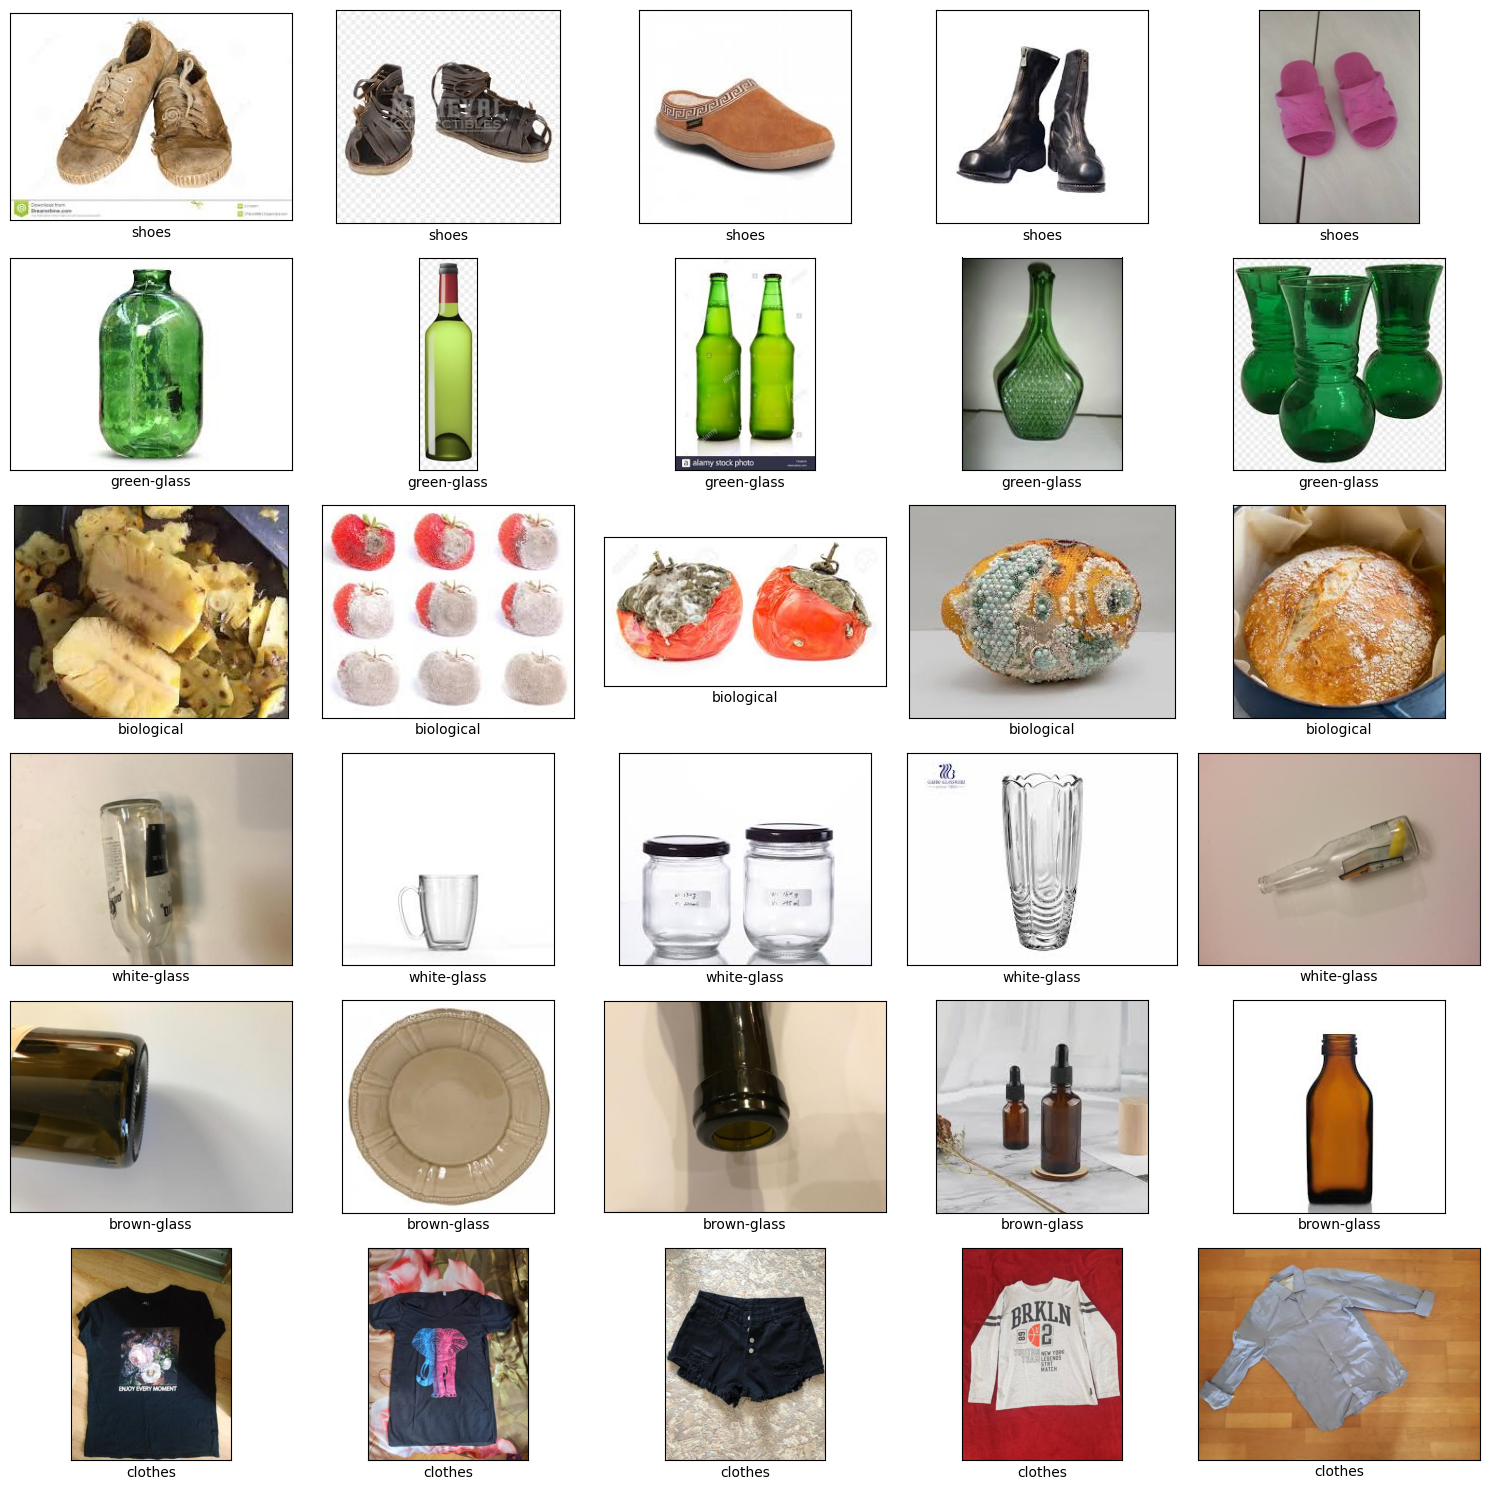

In [13]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = "/content/main/garbage_classification/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
path_sub = "/content/main/garbage_classification/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("RGB")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

**Membuat kelas baru berdasarkan kesamaan**

**Note:** Kelas-kelas brown-glass, green-glass, white-glass memiliki kesamaan tinggi dan hanya terdapat perbedaan pada bagian warna. Maka Kelas-kelas tersebut akan dijadikan satu kelas bernama "glass" agar model lebih baik akurasinya

In [14]:
# Dictionary untuk membuat kelas baru
new_category = {
    "brown-glass": "glass",
    "green-glass": "glass",
    "white-glass": "glass",
    "clothes": "clothes",
    "shoes": "shoes",
    "biological": "biological"
}

In [15]:
# Direktori sumber dan tujuan
source_dir = "/content/main/garbage_classification/dataset"
new_category_dir = "/content/main/garbage_classification/dir_new_category"

# Membuat direktori tujuan jika belum ada
os.makedirs(new_category_dir, exist_ok=True)

# Iterasi melalui setiap kelas dalam direktori sumber
for class_name in os.listdir(source_dir):
    source_class_dir = os.path.join(source_dir, class_name)

    # Periksa apakah direktori sumber valid
    if os.path.isdir(source_class_dir):
        # Dapatkan kelas baru dari new_category
        new_class_name = new_category.get(class_name)

        # Buat direktori untuk kelas baru jika belum ada
        destination_class_dir = os.path.join(new_category_dir, new_class_name)
        os.makedirs(destination_class_dir, exist_ok=True)

        # Pindahkan gambar ke direktori kelas baru
        for image_name in os.listdir(source_class_dir):
            source_image_path = os.path.join(source_class_dir, image_name)
            destination_image_path = os.path.join(destination_class_dir, image_name)
            shutil.copy(source_image_path, destination_image_path)

In [16]:
# Iterasi setiap kelas di dalam direktori kategori baru
for class_name in os.listdir(new_category_dir):
    class_path = os.path.join(new_category_dir, class_name)

    # Pastikan ini adalah direktori
    if os.path.isdir(class_path):
        # Ambil semua file gambar dan urutkan
        images = sorted([
            file for file in os.listdir(class_path)
            if file.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

        # Rename file satu per satu
        for idx, image_name in enumerate(images, start=1):
            ext = os.path.splitext(image_name)[1].lower()
            new_name = f"{class_name}{idx}{ext}"
            old_path = os.path.join(class_path, image_name)
            new_path = os.path.join(class_path, new_name)
            os.rename(old_path, new_path)

**Plot setiap kelas**

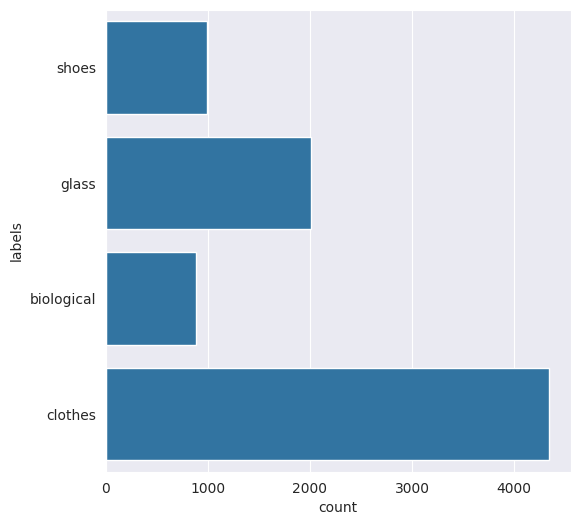

In [17]:
# Definisikan path sumber
lung_path = "/content/main/garbage_classification/dir_new_category/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_class = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_class['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#### Data Augmentasi

In [18]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

In [19]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transform5 = { 'rotate anticlockwise': anticlockwise_rotation,
                'rotate clockwise': clockwise_rotation,
                'add brightness' : add_brightness,
                'flip up down': flip_up_down,
                'blur image': blur_image
              }

transform2 = { 'rotate anticlockwise': anticlockwise_rotation,
                'rotate clockwise': clockwise_rotation
              }

In [21]:
# Direktori data hasil augmentasi
data_augmented5 = "/content/main/garbage_classification/data_augmented5"
os.makedirs(data_augmented5, exist_ok=True)

# Iterasi di new_category_dir
for class_name in os.listdir(new_category_dir):
    if class_name not in ["shoes", "biological"]:
        continue

    class_path = os.path.join(new_category_dir, class_name)
    augmented_class_path = os.path.join(data_augmented5, class_name)
    os.makedirs(augmented_class_path, exist_ok=True)


    if os.path.isdir(class_path):
        # Sort semua image
        images = sorted([
            file for file in os.listdir(class_path)
            if file.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            for transformation_name, transformation_func in transform5.items():
                transformed_image = transformation_func(img.copy())
                transformed_image = img_as_ubyte(transformed_image)
                transformed_img_name = f"{img_name[:-4]}_{transformation_name}{img_name[-4:]}"
                transformed_img_path = os.path.join(augmented_class_path, transformed_img_name)
                cv2.imwrite(transformed_img_path, transformed_image)

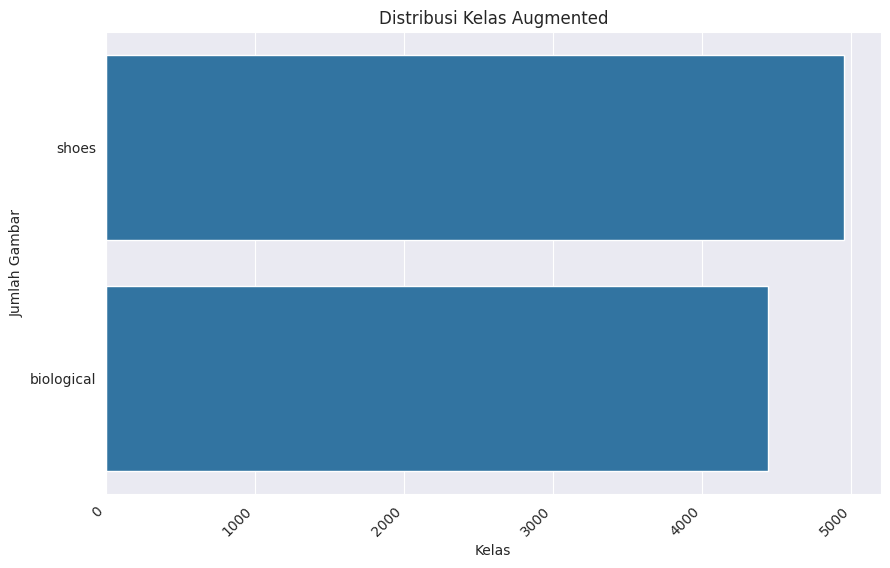

In [22]:
# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(data_augmented5):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Membuat dataset baru untuk menyimpan hasilnya
distribution_class_augmented = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Plot distribusi datanya
Label = distribution_class_augmented['labels']
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)
plt.title("Distribusi Kelas Augmented")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45, ha='right')
plt.show()

In [23]:
# Direktori data hasil augmentasi
data_augmented2 = "/content/main/garbage_classification/data_augmented2"
os.makedirs(data_augmented2, exist_ok=True)

# Iterasi di new_category_dir
for class_name in os.listdir(new_category_dir):
    if class_name != "glass":
        continue

    class_path = os.path.join(new_category_dir, class_name)
    augmented_class_path = os.path.join(data_augmented2, class_name)
    os.makedirs(augmented_class_path, exist_ok=True)


    if os.path.isdir(class_path):
        # Sort semua image
        images = sorted([
            file for file in os.listdir(class_path)
            if file.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            for transformation_name, transformation_func in transform2.items():
                transformed_image = transformation_func(img.copy())
                transformed_image = img_as_ubyte(transformed_image)
                transformed_img_name = f"{img_name[:-4]}_{transformation_name}{img_name[-4:]}"
                transformed_img_path = os.path.join(augmented_class_path, transformed_img_name)
                cv2.imwrite(transformed_img_path, transformed_image)

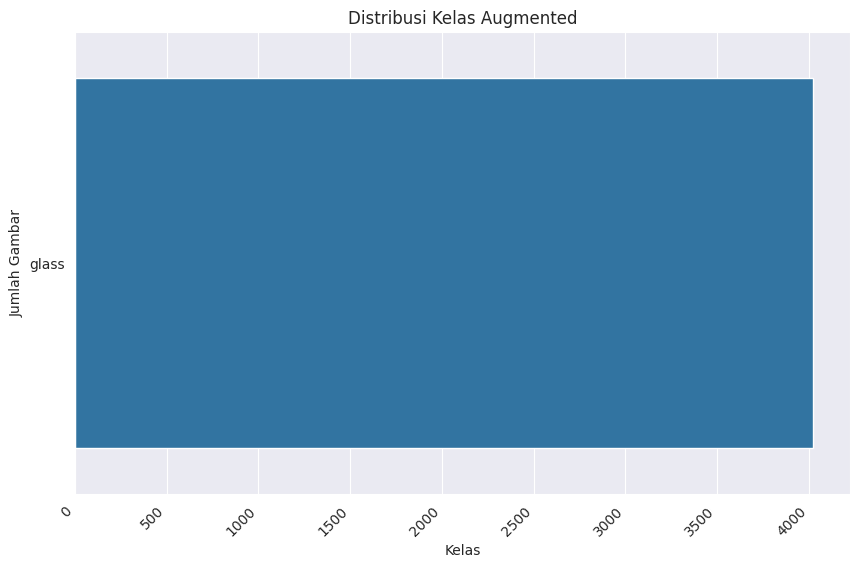

In [24]:
# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(data_augmented2):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Membuat dataset baru untuk menyimpan hasilnya
distribution_class_augmented = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Plot distribusi datanya
Label = distribution_class_augmented['labels']
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)
plt.title("Distribusi Kelas Augmented")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45, ha='right')
plt.show()

In [25]:
# Mendefinisikan direktori yang akan dipakai
data_augmented5_dir = "/content/main/garbage_classification/data_augmented5"
data_augmented2_dir = "/content/main/garbage_classification/data_augmented2"
clothes_dir = "/content/main/garbage_classification/dataset/clothes"

# Membuat direktori baru untuk menyimpan hasilnya
combined_dataset_dir = "/content/main/garbage_classification/dataset_combined"
os.makedirs(combined_dataset_dir, exist_ok=True)

# Copy data augmented4 ke combined dataset
for class_name in os.listdir(data_augmented5_dir):
    source_class_path = os.path.join(data_augmented5_dir, class_name)
    destination_class_path = os.path.join(combined_dataset_dir, class_name)
    os.makedirs(destination_class_path, exist_ok=True)

    for filename in os.listdir(source_class_path):
        source_file = os.path.join(source_class_path, filename)
        destination_file = os.path.join(destination_class_path, filename)
        shutil.copy(source_file, destination_file)


# Copy data augmented3 ke combined dataset
for class_name in os.listdir(data_augmented2_dir):
    source_class_path = os.path.join(data_augmented2_dir, class_name)
    destination_class_path = os.path.join(combined_dataset_dir, class_name)
    os.makedirs(destination_class_path, exist_ok=True)

    for filename in os.listdir(source_class_path):
        source_file = os.path.join(source_class_path, filename)
        destination_file = os.path.join(destination_class_path, filename)
        shutil.copy(source_file, destination_file)

# Copy data clothes ke combined dataset
destination_clothes_path = os.path.join(combined_dataset_dir, "fabric")
os.makedirs(destination_clothes_path, exist_ok=True)

for filename in os.listdir(clothes_dir):
    source_file = os.path.join(clothes_dir, filename)
    destination_file = os.path.join(destination_clothes_path, filename)
    shutil.copy(source_file, destination_file)

print(f"Combined dataset created at: {combined_dataset_dir}")

Combined dataset created at: /content/main/garbage_classification/dataset_combined


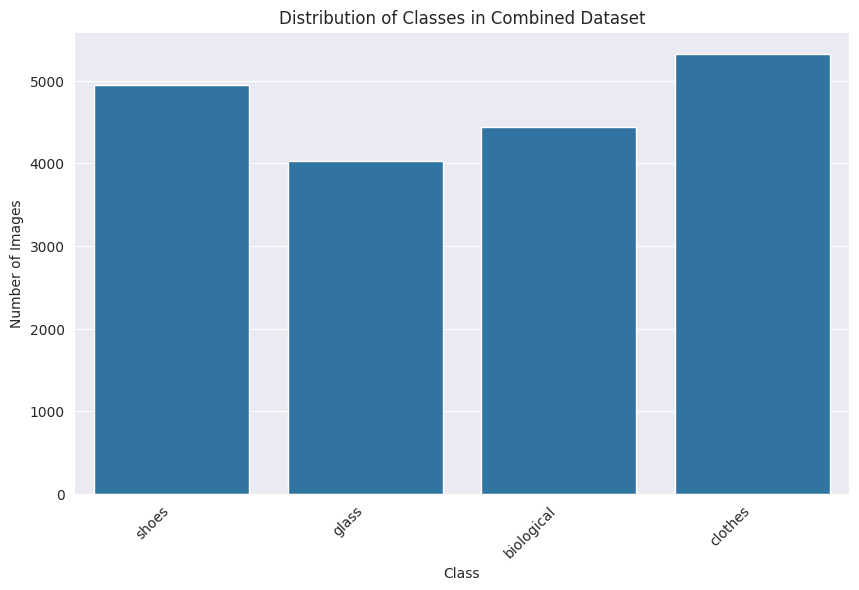

In [26]:
# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(combined_dataset_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Membuat dataset baru untuk menyimpan hasilnya
distribution_df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})
distribution_df['labels'] = distribution_df['labels'].replace({'fabric': 'clothes'})

# Plot the updated distribution
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x="labels", data=distribution_df)
plt.title("Distribution of Classes in Combined Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')
plt.show()

#### Split Dataset

In [27]:
# Split data into training, validation, and testing sets
X = distribution_df['path']
y = distribution_df['labels']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [28]:
print("Panjang data train:", len(X_train))
print("Panjang data test:", len(X_test))
print("Panjang data validasi:", len(X_val))

Panjang data train: 13115
Panjang data test: 2811
Panjang data validasi: 2811


In [29]:
# Menyatukan ke masing-masing dataframe
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test})

In [30]:
# Tambahkan kolom 'set' dengan copy untuk menghindari chained assignment issue
df_tr = df_tr.copy()
df_tr['set'] = 'train'
df_tr = df_tr.rename(columns={'label': 'labels'})

df_te = df_te.copy()
df_te['set'] = 'test'
df_te = df_te.rename(columns={'label': 'labels'})

df_val = df_val.copy()
df_val['set'] = 'val'
df_val = df_val.rename(columns={'label': 'labels'})

In [31]:
df_all = pd.concat([df_tr, df_te, df_val], ignore_index=True)

# Group by set dan label
print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek beberapa sampel acak
print(df_all.sample(5))


set    labels    
test   biological     666
       clothes        799
       glass          604
       shoes          742
train  biological    3108
       clothes       3727
       glass         2815
       shoes         3465
val    biological     666
       clothes        799
       glass          603
       shoes          743
dtype: int64 


                                                    path      labels    set
3233   /content/main/garbage_classification/dataset_c...       glass  train
9336   /content/main/garbage_classification/dataset_c...       shoes  train
13650  /content/main/garbage_classification/dataset_c...  biological   test
7171   /content/main/garbage_classification/dataset_c...  biological  train
15881  /content/main/garbage_classification/dataset_c...     clothes   test


#### Image Data Generator

In [40]:
TARGET_SIZE = (64,64)
BATCH_SIZE = 64

In [41]:
# Definisikan direktori untuk train, test dan validation
train_dir = 'data/train'
test_dir = 'data/test'
val_dir = 'data/val'

# Membuat direktori
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [42]:
# Fungsi untuk menyimpan gambar ke direktori masing-masing
def save_images_to_directories(df, base_dir):
    for index, row in df.iterrows():
        image_path = row['path']
        label = row['labels']

        # Buat path direktori untuk label
        label_dir = os.path.join(base_dir, label)

        # Buat direktori jika belum ada
        os.makedirs(label_dir, exist_ok=True)

        # Nama file gambar
        filename = os.path.basename(image_path)

        # Path tujuan untuk gambar
        destination_path = os.path.join(label_dir, filename)

        # Copy gambar ke direktori tujuan
        shutil.copy2(image_path, destination_path)


# Pastikan df_tr, df_val, dan df_te sudah didefinisikan
save_images_to_directories(df_tr, train_dir)
save_images_to_directories(df_val, val_dir)
save_images_to_directories(df_te, test_dir)

In [43]:
# Buat objek ImageDataGenerator yang menormalkan gambar
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size= TARGET_SIZE,
    batch_size= BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size= TARGET_SIZE,
    batch_size= BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size= TARGET_SIZE,
    batch_size= BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 13115 images belonging to 4 classes.
Found 2811 images belonging to 4 classes.
Found 2811 images belonging to 4 classes.


## Modelling

In [44]:
####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(64,64,3)))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(64, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(64, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_1.add(Dense(4, activation='softmax'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801,860 (3.06 MB)

 Trainable params: 801,476 (3.06 MB)

 Non-trainable params: 384 (1.50 KB)

None


**1. Mengimplementasikan Callback**

In [45]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(1.0549388674388673), 1: np.float64(0.8797290045613093), 2: np.float64(1.1647424511545292), 3: np.float64(0.9462481962481962)}


In [46]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
callbacks_list = [early_stopping, model_checkpoint]

# Fitting / training model
history_1 = model_1.fit(
    train_generator,
    epochs=30,
    batch_size=BATCH_SIZE,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks_list
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4951 - loss: 1.3555

205/205 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.4954 - loss: 1.3543 - val_accuracy: 0.4223 - val_loss: 1.8298
Epoch 2/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6369 - loss: 0.9171

205/205 ━━━━━━━━━━━━━━━━━━━━ 470s 2s/step - accuracy: 0.6370 - loss: 0.9169 - val_accuracy: 0.6357 - val_loss: 0.8936
Epoch 3/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7138 - loss: 0.7620

205/205 ━━━━━━━━━━━━━━━━━━━━ 467s 2s/step - accuracy: 0.7138 - loss: 0.7619 - val_accuracy: 0.8196 - val_loss: 0.5236
Epoch 4/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 466s 2s/step - accuracy: 0.7528 - loss: 0.6671 - val_accuracy: 0.6741 - val_loss: 0.8235
Epoch 5/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 462s 2s/step - accuracy: 0.7782 - loss: 0.6042 - val_accuracy: 0.6571 - val_loss: 0.8495
Epoch 6/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.8031 - loss: 0.5530 - val_accuracy: 0.8022 - val_loss: 0.4878
Epoch 7/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 504s 2s/step - accuracy: 0.8191 - loss: 0.5094 - val_accuracy: 0.8047 - val_loss: 0.5073
Epoch 8/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 459s 2s/step - accuracy: 0.8258 - loss: 0.4853 - val_accuracy: 0.7986 - val_loss: 0.5265
Epoch 9/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8321 - loss: 0.4897

205/205 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.8321 - loss: 0.4897 - val_accuracy: 0.8385 - val_loss: 0.4202
Epoch 10/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8521 - loss: 0.4360

205/205 ━━━━━━━━━━━━━━━━━━━━ 482s 2s/step - accuracy: 0.8521 - loss: 0.4360 - val_accuracy: 0.8687 - val_loss: 0.3724
Epoch 11/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - accuracy: 0.8482 - loss: 0.4305 - val_accuracy: 0.8670 - val_loss: 0.3538
Epoch 12/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - accuracy: 0.8612 - loss: 0.4031 - val_accuracy: 0.7552 - val_loss: 0.6286
Epoch 13/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - accuracy: 0.8615 - loss: 0.4011 - val_accuracy: 0.8328 - val_loss: 0.4546
Epoch 14/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 460s 2s/step - accuracy: 0.8673 - loss: 0.3773 - val_accuracy: 0.8630 - val_loss: 0.3587
Epoch 15/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.8711 - loss: 0.3661 - val_accuracy: 0.8107 - val_loss: 0.4971
Epoch 16/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 481s 2s/step - accuracy: 0.8766 - loss: 0.3606 - val_accuracy: 0.8314 - val_loss: 0.4089


## Evaluasi dan Visualisasi

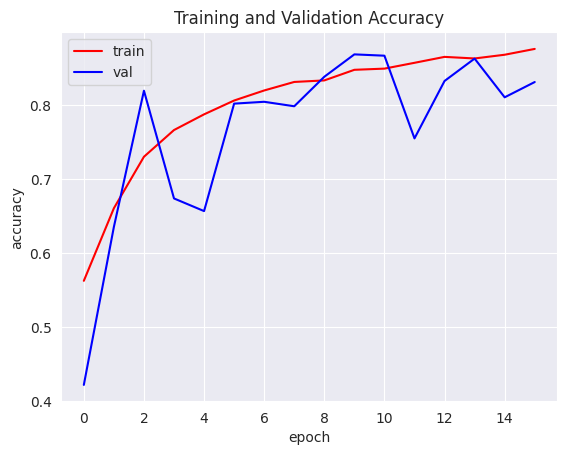

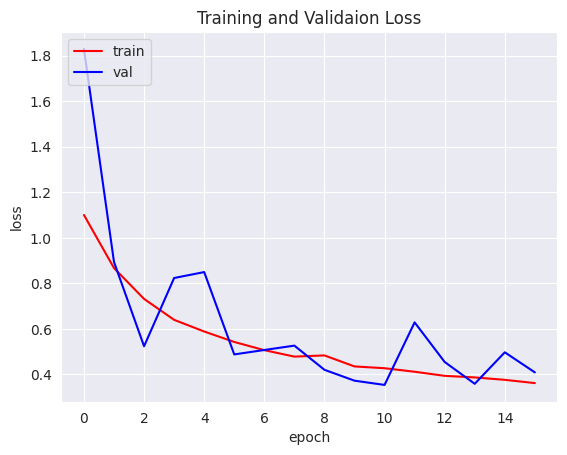

In [47]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix
# Membuat prediksi dari test_generator
predictions = model_1.predict(test_generator)

# Convert prediksi dalam biner
predicted_labels = np.argmax(predictions, axis=1)

# Mendapatkan label dari test_generator
true_labels = test_generator.classes
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy test set: {accuracy}")

# Membuat confusion_matrix
cm = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
cm_df = pd.DataFrame(cm, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())
cm_df

44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 538ms/step
Accuracy test set: 0.8534329420135183
Confusion Matrix:


,biological,clothes,glass,shoes
biological,612,6,14,34
clothes,47,728,1,23
glass,48,2,490,64
shoes,128,25,20,569


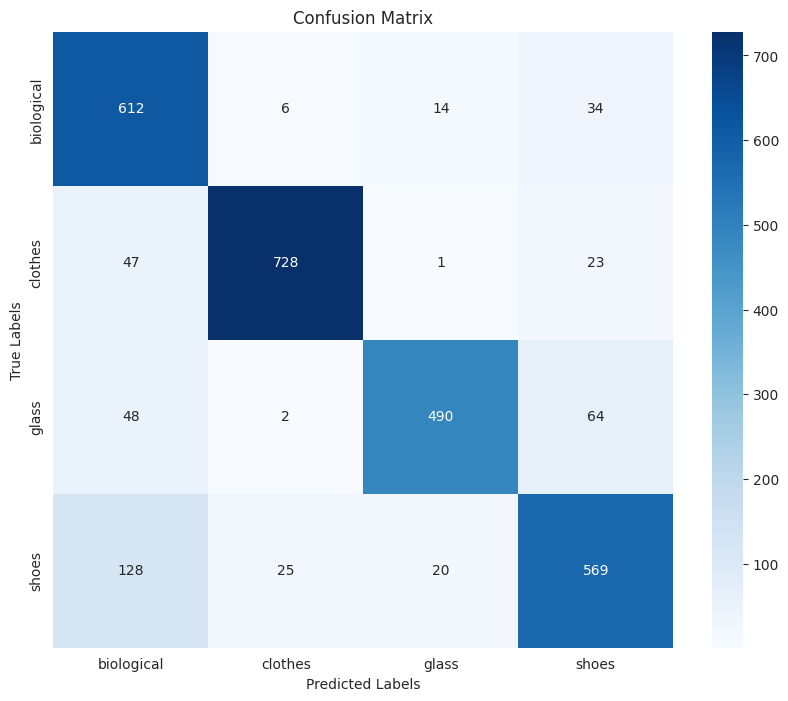

In [51]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Konversi Model

**1. SavedModel**

In [52]:
# Simpan model dalam format SavedModel
export_dir = 'saved_model'
tf.saved_model.save(model_1, export_dir)

# Periksa direktori SavedModel
!ls -l saved_model

total 248
drwxr-xr-x 2 root root   4096 Apr 25 04:12 assets
-rw-r--r-- 1 root root     57 Apr 25 04:12 fingerprint.pb
-rw-r--r-- 1 root root 237879 Apr 25 04:12 saved_model.pb
drwxr-xr-x 2 root root   4096 Apr 25 04:12 variables


**2. TF-Lite**

In [53]:
os.makedirs('tflite', exist_ok=True)

# Misal: path folder tempat model disimpan
export_dir = 'saved_model/'

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Simpan model TFLite ke folder 'tflite'
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

**3. TFJS**

In [55]:
!pip install tensorflowjs

import tensorflowjs as tfjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [56]:
export_dir = 'saved_model'
tf.saved_model.save(model_1, export_dir)

# Konversi model ke format TFJS
!tensorflowjs_converter --input_format=tf_saved_model saved_model tfjs_model

# Periksa direktori TFJS model
!ls -l tfjs_model

2025-04-25 04:17:53.958002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745554674.032438   52733 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745554674.044933   52733 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-25 04:18:06.048309: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1745554686.318233   52733 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

## Inference (Optional)